## Setup

In [2]:
# Import Dependencies.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [3]:
# Fetch the data from the API.
listings_json = requests.get("http://127.0.0.1:5000/api/v1.0/listings").json()

# Examine the data.
print(json.dumps(listings_json[0], indent=4, sort_keys=True))

{
    "address": "17452 NE GLISAN ST #7, Portland OR 97230",
    "bathrooms": 2.0,
    "bedrooms": 2,
    "built": 1988,
    "city": "Portland",
    "county": "Multnomah",
    "elementary_school": "Hartley",
    "high_school": "Reynolds",
    "home_type": "Manufactured - Double Wide Manufact",
    "lot_size": null,
    "middle_school": "Reynolds",
    "neighborhood": "unknown",
    "price": 72000,
    "square_feet": 1152,
    "zipcode": 97230
}


In [4]:
# Create a dataframe to use for our model.
data_df = pd.DataFrame(listings_json)

print(len(data_df))
data_df.head()

1822


,address,bathrooms,bedrooms,built,city,county,elementary_school,high_school,home_type,lot_size,middle_school,neighborhood,price,square_feet,zipcode
0,"17452 NE GLISAN ST #7, Portland OR 97230",2.0,2,1988,Portland,Multnomah,Hartley,Reynolds,Manufactured - Double Wide Manufact,NaN,Reynolds,unknown,72000,1152,97230
1,"16000 SE POWELL BLVD 75, Portland OR 97236",2.0,3,1990,Portland,Multnomah,Powell Butte,Centennial,Manufactured - Double Wide Manufact,NaN,Centennial,unknown,79950,1404,97236
2,"12846 SE RAMONA ST 6, Portland OR 97236",2.0,3,1997,Portland,Multnomah,Gilbert Hts,David Douglas,Manufactured - Double Wide Manufact,NaN,Alice Ott,unknown,93900,1297,97236
3,"7720 S Macadam AVE 7, Portland OR 97219",3.0,3,1988,Portland,Multnomah,Other,Other,Floating Home - Contemporary,NaN,Other,unknown,125000,2432,97219
4,"19609 NE Marine DR E-4, Portland OR 97230",1.0,1,1960,Portland,Multnomah,Salish Pond,Reynolds,Floating Home - Cabin,NaN,Reynolds,unknown,129500,735,97230


## Data Preprocessing

In [11]:
# Make a copy of the original data frame to modify.
model_df = data_df

# Insert a lot value of 0 for condos and floating homes.
for index, row in model_df.iterrows():
    if ("Condo" in row["home_type"]) | ("Floating" in row["home_type"]):
        model_df.loc[index, "lot_size"] = 0
    else:
        pass

# Include only those columns that will be used in the deep learning model.
model_df = model_df.loc[:, ["bathrooms", "bedrooms", "built", "lot_size", "square_feet", "price"]]
# Chose not to include high_school due to lousy random forest fitting.
# Drop rows with NaN entries.
model_df.dropna(inplace=True)

# Check the model data.
print(len(model_df))
model_df.head()

1725


,bathrooms,bedrooms,built,lot_size,square_feet,price
3,3.0,3,1988,0.0,2432,125000
4,1.0,1,1960,0.0,735,129500
5,1.0,1,1974,0.0,720,141900
6,1.0,1,1927,0.0,382,144900
7,1.0,1,2004,0.0,513,149900


In [12]:
# Assign X (input) and y (target).

X = model_df.loc[:, ["bathrooms", "bedrooms", "square_feet", "lot_size", "built"]]
y = model_df.loc[:,"price"].values.reshape(-1, 1)

In [13]:
# Split the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [15]:
# Transform the training and testing data using the X_scaler and y_scaler models.

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Model Creation, Training, and Testing

In [16]:
# Create a LinearRegression model and fit it to the scaled training data

model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

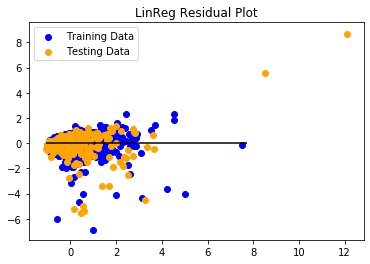

7.738646964398389

In [33]:
# Make predictions using a fitted model.
# Plot the difference between the model predicted values and actual y values, versus the model predicted values.

plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("LinReg Residual Plot")
plt.show()
y_test_scaled.max()

In [19]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2.

predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.8565737703913088, R2: 0.40785841450261595


In [20]:
# LASSO model.

lasso = GridSearchCV(Lasso(), {"alpha":10.0 ** -np.arange(1, 7)}, verbose=2)
lasso.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................ alpha=0.1, total=   0.2s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [22]:
# List the best parameters and best score for LASSO.
print(lasso.best_params_)
print(lasso.best_score_)

{'alpha': 0.01}
0.5867826563626133


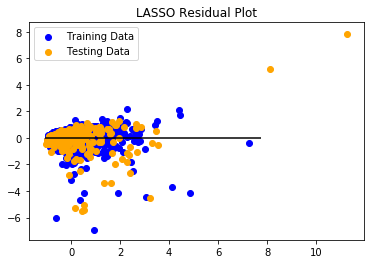

In [23]:
# Make predictions using a fitted lasso model.
# Plot the difference between the model predicted values and actual y values, versus the model predicted values.

plt.scatter(lasso.predict(X_train_scaled), lasso.predict(X_train_scaled) - list(np.ravel(y_train_scaled)), c="blue", label="Training Data")
plt.scatter(lasso.predict(X_test_scaled), lasso.predict(X_test_scaled) - list(np.ravel(y_test_scaled)), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("LASSO Residual Plot")
plt.show()

In [24]:
# Used X_test_scaled, y_test_scaled, and lasso.predict(X_test_scaled) to calculate MSE and R2.

lasso_predictions = lasso.predict(X_test_scaled)
lasso_MSE = mean_squared_error(y_test_scaled, lasso_predictions)
lasso_r2 = lasso.score(X_test_scaled, y_test_scaled)

print(f"MSE: {lasso_MSE}, R2: {lasso_r2}")

MSE: 0.8213364908797424, R2: 0.4322176224072211


In [25]:
# Ridge model.

ridge = GridSearchCV(Ridge(), {"alpha":10.0 ** -np.arange(1, 7)}, verbose=2)
ridge.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................ alpha=0.1, total=   0.4s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [31]:
# List the best parameters and best score for Ridge.
print(ridge.best_params_)
print(ridge.best_score_)

{'alpha': 0.1}
0.5865729291914047


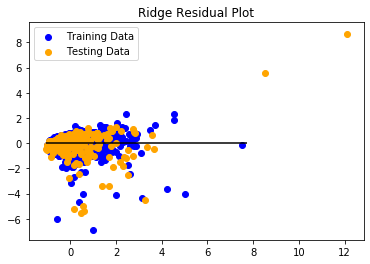

In [27]:
# Make predictions using a fitted ridge model.
# Plot the difference between the model predicted values and actual y values, versus the model predicted values.

plt.scatter(ridge.predict(X_train_scaled), ridge.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(ridge.predict(X_test_scaled), ridge.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Ridge Residual Plot")
plt.show()

In [28]:
# Used X_test_scaled, y_test_scaled, and ridge.predict(X_test_scaled) to calculate MSE and R2.

ridge_predictions = ridge.predict(X_test_scaled)
ridge_MSE = mean_squared_error(y_test_scaled, ridge_predictions)
ridge_r2 = ridge.score(X_test_scaled, y_test_scaled)

print(f"MSE: {ridge_MSE}, R2: {ridge_r2}")

MSE: 0.8566696154397656, R2: 0.4077921577003216


In [29]:
# ElasticNet model, we'll use gridsearch later to try out different alpha values later.

elast = GridSearchCV(ElasticNet(), {"alpha":10.0 ** -np.arange(1, 7)}, verbose=2)
elast.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [30]:
# List the best parameters and best score for ElasticNet.
print(elast.best_params_)
print(elast.best_score_)

{'alpha': 0.01}
0.5869966792244832


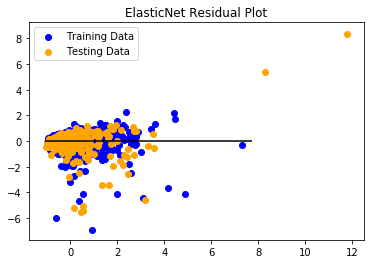

In [32]:
# Make predictions using a fitted elasticnet model.
# Plot the difference between the model predicted values and actual y values, versus the model predicted values.

plt.scatter(elast.predict(X_train_scaled), elast.predict(X_train_scaled) - list(np.ravel(y_train_scaled)), c="blue", label="Training Data")
plt.scatter(elast.predict(X_test_scaled), elast.predict(X_test_scaled) - list(np.ravel(y_test_scaled)), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("ElasticNet Residual Plot")
plt.show()

In [34]:
# Used X_test_scaled, y_test_scaled, and elast.predict(X_test_scaled) to calculate MSE and R2.

elast_predictions = elast.predict(X_test_scaled)
elast_MSE = mean_squared_error(y_test_scaled, elast_predictions)
elast_r2 = elast.score(X_test_scaled, y_test_scaled)

print(f"MSE: {elast_MSE}, R2: {elast_r2}")

MSE: 0.8442298461988296, R2: 0.4163916559994399
